In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/kddcup.data_0_1_percent.csv', sep=',')
df.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,32,33,34,35,36,37,38,39,40,41
0,22650,1,tcp,smtp,SF,1022,389,0,0,0,...,175,0.64,0.02,0.01,0.02,0.0,0.0,0.0,0.0,normal.
1,5765,0,tcp,http,SF,376,285,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
2,241826,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.


In [17]:
# filter labels
labels = df['41']  # get labels
label_counts = labels.value_counts()  # n-obs / label
mask = label_counts > df.shape[0] * 0.05  # label must encompass > 5% of the data
valid_labels = label_counts.index[mask]  # get passing labels
print(f'Passing labels = {valid_labels.tolist()}')
model_df = df[df['41'].isin(valid_labels)]
labels = model_df['41']  # redefine labels
col_dummy = model_df['2']
model_df = model_df.drop(columns=['Unnamed: 0', '0', '1', '2', '3'])

Passing labels = ['smurf.', 'neptune.', 'normal.']


In [18]:
# Define columns to use (numeric features) – I excluded 'Unnamed: 0'
features = ['4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21',
           '22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40']
# specify the metrics column names to be modeled
to_model_columns = df.filter(items=features).columns

In [19]:
# split data
# - if it's an intrusion
mask_normal, mask_anomaly = labels=='normal.', labels!='normal.'  # get masks
df_normal, df_anomaly = model_df[mask_normal], model_df[mask_anomaly]  # subset data

# - set seed
import random
random_state = 0
random.seed(random_state)
np.random.seed(0)

# - normal ml splitting
from sklearn.model_selection import train_test_split
X, y = df_normal.select_dtypes(['number']), labels[mask_normal]  # last column is label
params = train_test_split(X, y, test_size=1/4, random_state=random_state, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = params

# - anomaly ml splitting
X_test_anomaly, y_test_anomaly = df_anomaly.select_dtypes(['number']), labels[mask_anomaly]

# fit model - utilizes "density" splitting such that majority of data stays together
from sklearn.ensemble import IsolationForest
model = IsolationForest(random_state=0)
model.fit(X_train)

# predict on model_df
pred = model.predict(model_df[to_model_columns])

# add col 'anomaly' and filter na values (there shouldn't be any but still)
model_df['anomaly'] = pred

In [6]:
model_df.head(3)

,4,5,6,7,8,9,10,11,12,13,...,33,34,35,36,37,38,39,40,41,anomaly
0,1022,389,0,0,0,0,0,1,0,0,...,0.64,0.02,0.01,0.02,0.0,0.0,0.0,0.0,normal.,1
1,376,285,0,0,0,0,0,1,0,0,...,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.,1
2,1032,0,0,0,0,0,0,0,0,0,...,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.,-1


### One Hot Encoding

In [7]:
col_dummy.value_counts().head(5)

ecr_i       281135
private     108683
http         62078
smtp          9718
domain_u      5862
Name: 2, dtype: int64

In [20]:
values = ['ecr_i', 'private', 'http', 'smtp']
col_dummy.loc[~col_dummy.isin(values)] = 'others'
values.append('others')
col_dummy.value_counts()

/Users/minkim/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


ecr_i      281135
private    108683
http        62078
others      23655
smtp         9718
Name: 2, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### integer mapping using LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(col_dummy)
print(integer_encoded)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

### One hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

print(onehot_encoded)

[4 1 0 ... 0 0 3]
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [22]:
one_hot = pd.get_dummies(col_dummy)
# Join the encoded df
model_df = model_df.join(one_hot)
model_df = model_df[model_df.anomaly.notna()]
model_df

,4,5,6,7,8,9,10,11,12,13,...,38,39,40,41,anomaly,ecr_i,http,others,private,smtp
0,1022,389,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,normal.,1,0,0,0,0,1
1,376,285,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,normal.,1,0,1,0,0,0
2,1032,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,smurf.,-1,1,0,0,0,0
3,1032,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,smurf.,-1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,neptune.,-1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,520,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,smurf.,-1,1,0,0,0,0
494017,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,neptune.,-1,0,0,0,1,0
494018,520,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,smurf.,-1,1,0,0,0,0
494019,1032,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,smurf.,-1,1,0,0,0,0


In [23]:
for val in values:
    features.append(val)

### Standardization

In [24]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
x = model_df.loc[:, features].values

# Separating out the column 41 (our target)
y = model_df.loc[:,['41']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[ 1.62155339e-02, -1.71508554e-02, -1.43551975e-03, ...,
        -3.83001652e-01,  6.99536053e+00, -2.26371626e-01],
       [-2.59226747e-02, -2.33122586e-02, -1.43551975e-03, ...,
         2.61095480e+00, -1.42951889e-01, -2.26371626e-01],
       [ 1.68678282e-02, -4.01968733e-02, -1.43551975e-03, ...,
        -3.83001652e-01, -1.42951889e-01, -2.26371626e-01],
       ...,
       [-1.65296375e-02, -4.01968733e-02, -1.43551975e-03, ...,
        -3.83001652e-01, -1.42951889e-01, -2.26371626e-01],
       [ 1.68678282e-02, -4.01968733e-02, -1.43551975e-03, ...,
        -3.83001652e-01, -1.42951889e-01, -2.26371626e-01],
       [-5.04489386e-02, -4.01968733e-02, -1.43551975e-03, ...,
        -3.83001652e-01, -1.42951889e-01, -2.26371626e-01]])

### t-SNE

In [27]:
from sklearn.manifold import TSNE

# first reduce dimensionality before feeding to t-sne
pca = PCA(n_components=5)
X_pca = pca.fit_transform(x) 

# randomly sample data to run quickly
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000 

# reduce dimensionality with t-sne
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
tsne_results

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.028s...
[t-SNE] Computed neighbors for 10000 samples in 0.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.635368
[t-SNE] KL divergence after 1000 iterations: 0.356800


array([[-15.664037, -22.446512],
       [-28.41347 ,  35.485474],
       [ 30.296936,  34.054604],
       ...,
       [-13.098764, -21.942135],
       [-32.5444  , -50.727   ],
       [-16.869068, -68.71181 ]], dtype=float32)

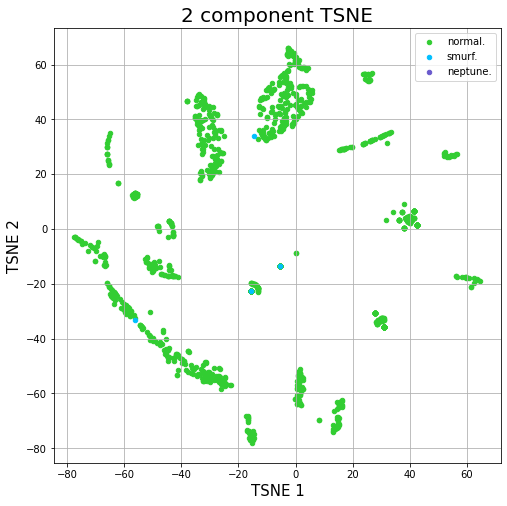

In [35]:
tsneDf = pd.DataFrame(data = tsne_results
             , columns = ['tsne1', 'tsne2'])
finalDf = pd.concat([tsneDf, model_df[['anomaly']]], axis = 1)
finalDf = pd.concat([finalDf, model_df[['41']]], axis=1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE 1', fontsize = 15)
ax.set_ylabel('TSNE 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = ['normal.', 'smurf.', 'neptune.']
colors = ['limegreen', 'deepskyblue', 'slateblue']
for target, color in zip(targets, colors):
    indicesToKeep = (finalDf['41'] == target) & (finalDf['anomaly'] == 1)
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , c = color
               , s = 20)
    
ax.legend(targets)
ax.grid()

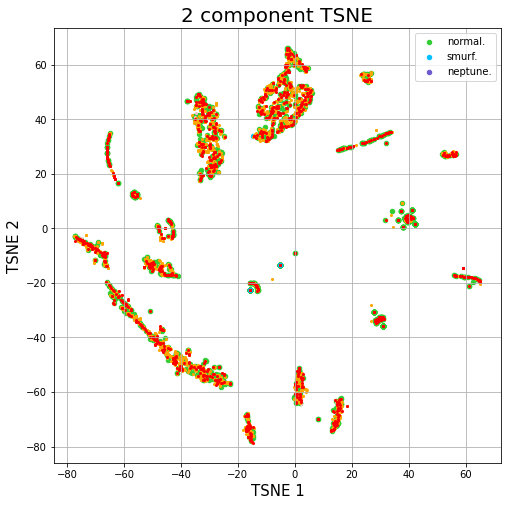

In [36]:
# with outliers

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE 1', fontsize = 15)
ax.set_ylabel('TSNE 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
    
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == target) & (finalDf['anomaly'] == 1)
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , c = color
               , s = 20)

# for anomalies: pink = normal, orange = smurf, red = neptune   
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == 'normal.') & (finalDf['anomaly'] == -1)
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , marker = 'x'
               , c = 'pink'
               , s = 3)
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == 'smurf.') & (finalDf['anomaly'] == -1)
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , marker = 'x'
               , c = 'orange'
               , s = 3)
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == 'neptune.') & (finalDf['anomaly'] == -1)
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , marker = 'x'
               , c = 'r'
               , s = 3)
    
ax.legend(targets)
ax.grid()

In [50]:
tsne = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

tsneDf = pd.DataFrame(data = tsne_results
             , columns = ['tsne1', 'tsne2', 'tsne3'])
finalDf = pd.concat([tsneDf, model_df[['anomaly']]], axis = 1)
finalDf = pd.concat([finalDf, model_df[['41']]], axis=1)

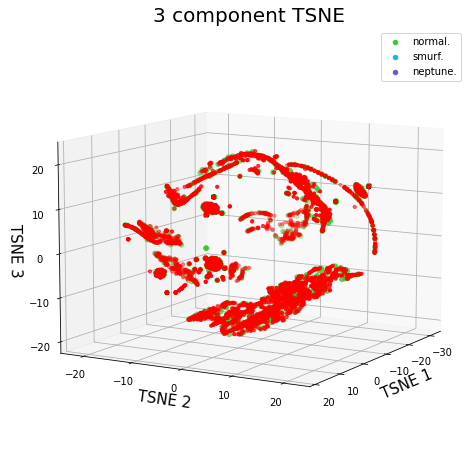

In [51]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('TSNE 1', fontsize = 15)
ax.set_ylabel('TSNE 2', fontsize = 15)
ax.set_zlabel('TSNE 3', fontsize = 15)
ax.set_title('3 component TSNE', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == target) & (finalDf['anomaly'] == 1)
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , finalDf.loc[indicesToKeep, 'tsne3']
               , c = color
               , s = 20)
    
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == target) & (finalDf['anomaly'] == -1)
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , finalDf.loc[indicesToKeep, 'tsne3']
               , c = 'r'
               , s = 10)

ax.view_init(10, 30)
ax.legend(targets)
plt.show()

### UMAP

In [37]:
import umap as UMAP

pca = PCA(n_components = 5)
principalComponents = pca.fit_transform(x)
umap_2d = UMAP(n_components=2, init='random', random_state=0)
umapDf = umap_2d.fit_transform(principalComponents)
umapDf = pd.DataFrame(data = umapDf
             , columns = ['umap1', 'umap2'])
finalDf = pd.concat([umapDf, model_df[['anomaly']]], axis = 1)
finalDf = pd.concat([finalDf, model_df[['41']]], axis=1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('UMAP 1', fontsize = 15)
ax.set_ylabel('UMAP 2', fontsize = 15)
ax.set_title('2 component UMAP', fontsize = 20)
targets = ['normal.', 'smurf.', 'neptune.']
colors = ['limegreen', 'deepskyblue', 'slateblue']
for target, color in zip(targets, colors):
    indicesToKeep = (finalDf['41'] == target) & (finalDf['anomaly'] == 1)
    ax.scatter(finalDf.loc[indicesToKeep, 'umap1']
               , finalDf.loc[indicesToKeep, 'umap2']
               , c = color
               , s = 20)
    
ax.legend(targets)
ax.grid()

In [47]:
umap_3d = UMAP(n_components=3, init='random', random_state=0)
umap_3d = umap_3d.fit_transform(principalComponents)
umapDf = umap_3d.fit_transform(principalComponents)
umapDf = pd.DataFrame(data = umapDf
             , columns = ['umap1', 'umap2', 'umap3'])
finalDf = pd.concat([umapDf, model_df[['anomaly']]], axis = 1)
finalDf = pd.concat([finalDf, model_df[['41']]], axis=1)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('UMAP 1', fontsize = 15)
ax.set_ylabel('UMAP 2', fontsize = 15)
ax.set_zlabel('UMAP 3', fontsize = 15)
ax.set_title('3 component UMAP', fontsize = 20)

for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == target) & (finalDf['anomaly'] == 1)
    ax.scatter(finalDf.loc[indicesToKeep, 'umap1']
               , finalDf.loc[indicesToKeep, 'umap2']
               , finalDf.loc[indicesToKeep, 'umap3']
               , c = color
               , s = 20)
    
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['41'] == target) & (finalDf['anomaly'] == -1)
    ax.scatter(finalDf.loc[indicesToKeep, 'umap1']
               , finalDf.loc[indicesToKeep, 'umap2']
               , finalDf.loc[indicesToKeep, 'umap3']
               , c = 'r'
               , s = 10)

ax.view_init(10, 30)
ax.legend(targets)
plt.show()

TypeError: 'module' object is not callable